In [1]:
import numpy as np
import os

from copy import deepcopy
from pommerman.agents import SimpleAgent
from pommerman.configs import ffa_competition_env
from pommerman.constants import BOARD_SIZE
from pommerman.envs.v0 import Pomme
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

%matplotlib inline

Import error! You will not be able to render --> Cannot connect to "None"


In [145]:
initial_rollouts   = 600
min_episode_length = 35 

train_data_path    = './dataset/'
train_data_obs     = os.path.join(train_data_path, 'obs.npy')
train_data_labels  = os.path.join(train_data_path, 'labels.npy')
train_data_reward  = os.path.join(train_data_path, 'reward.npy')
train_data_obs_map = os.path.join(train_data_path, 'obs_map.npy')

if not os.path.isdir(train_data_path):
    os.makedirs(train_data_path)

In [3]:
class Episode:   
    def __init__(self, agent_id, episode_id):
        self.agent_id = agent_id
        self.episode_id = episode_id
        self.observations = []
        self.actions = []
        self.reward = []
        self.done = False        
        
    def record(self, obs, action, reward):
        self.observations.append(deepcopy(obs))
        self.actions.append(deepcopy(action))
        # Agent not win or not die
        if reward != 0:
            self.done = True
            self.reward = [reward] * self.get_num_steps()
        
    def get_num_steps(self):
        return len(self.observations)        

In [4]:
# Environment wrapper
class Stimulator:
    def __init__(self, env):
        self.env = env
        self.episodes = []
        
    def record(self, agents, obs, actions, rewards):        
        for agent_id in range(len(agents)): 
            agent = agents[agent_id]
            # If an agent is dead (or win) we should not record a history
            if not agent.done:    
                agent.record(obs[agent_id], actions[agent_id], rewards[agent_id])

    def stimulate(self, num_rollouts):
        for cur_episode in tqdm(range(num_rollouts)):
            # Create a history for each agent
            agents = []                
            for agent_id in range(4):
                agents.append(Episode(agent_id, cur_episode))            
            
            done = False     
            # Obtain initial observations
            obs = self.env.reset()
            try:
                while not done:
                    # FUCK self.env.act change "POSITION"!!!!
                    obs_to_save = deepcopy(obs)                    
                    # Produce actions
                    actions = self.env.act(obs)
                    # Make an episode step. Save an observations as new_obs, because we want to record previous one
                    obs, rewards, done, _ = self.env.step(actions)
                    # Record observations and actions
                    self.record(agents, obs_to_save, actions, rewards)                    
            except:
                print("Error occurs")
                continue            
            self.episodes.extend(agents)
    
    def get_episodes(self):
        return deepcopy(self.episodes)

In [5]:
# Instantiate the environment
config = ffa_competition_env()
env = Pomme(**config["env_kwargs"])

# Random seed
env.seed(0)

# Add agents
agents = []
for agent_id in range(4):
    agents.append(SimpleAgent(config["agent"](agent_id, config["game_type"])))
env.set_agents(agents)
env.set_init_game_state(None)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
# Generate training data
stimulator = Stimulator(env)
stimulator.stimulate(initial_rollouts)

In [10]:
episodes = stimulator.get_episodes()
len(episodes)

2400

In [11]:
for episode in tqdm(episodes):
    for observation in episode.observations:
        board = observation['board']
        pos   = observation['position']    
        if board[pos[0], pos[1]] != (episode.agent_id + 10):
            print("ERROR")

## Win/Lose in corners

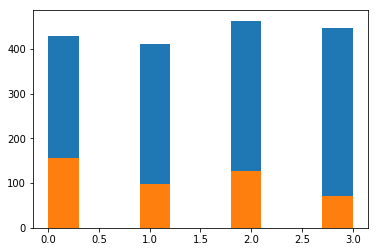

In [23]:
wins = []
loses = []

for episode in episodes:
    if episode.reward[-1] == -1:
        loses.append(episode.agent_id)
    elif episode.reward[-1] == 1:
        wins.append(episode.agent_id)
    else:
        print("FUCK")

plt.hist(loses)
plt.hist(wins)
plt.show()

In [24]:
np.bincount(loses)

array([429, 412, 463, 447])

## Episode length

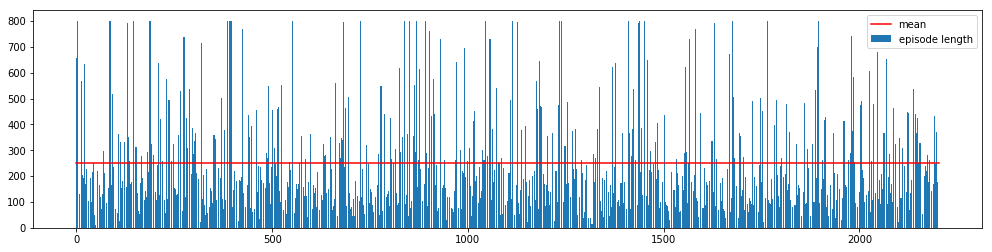

In [25]:
episode_length = []
for episode in episodes:
    episode_length.append(episode.get_num_steps())
    
plt.figure(figsize=(17,4))
plt.bar(range(0, len(episode_length)), episode_length)
plt.plot([0, len(episode_length)], [np.mean(episode_length), np.mean(episode_length)], 'r')
plt.legend(['mean', 'episode length'])
plt.show()

In [26]:
np.min(episode_length), np.max(episode_length), np.sum(np.array(episode_length) < 30)

(10, 801, 24)

## Rewards

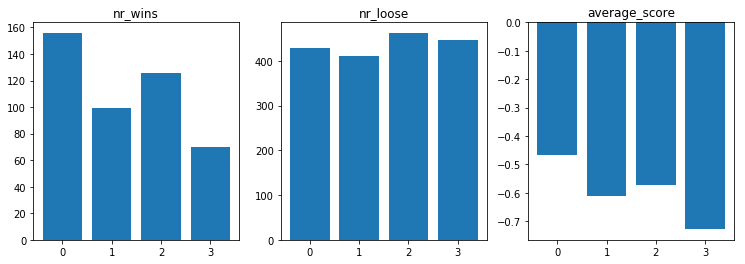

In [27]:
nr_wins = [0] * 4
nr_loose = [0] * 4
nr_tie = [0] * 4
average_score = [[], [], [], []]

for episode in episodes:
    if episode.reward[-1] == 1:
        nr_wins[episode.agent_id] += 1
    else:
        nr_loose[episode.agent_id] += 1
    average_score[episode.agent_id].append(episode.reward[-1])
average_score[0] = np.mean(average_score[0])
average_score[1] = np.mean(average_score[1])
average_score[2] = np.mean(average_score[2])
average_score[3] = np.mean(average_score[3])

plt.figure(figsize=(17,4))
plt.subplot(141)
plt.bar(range(0,4), nr_wins)
plt.title('nr_wins')
plt.subplot(142)
plt.bar(range(0,4), nr_loose)
plt.title('nr_loose')
plt.subplot(143)
plt.bar(range(0,4), average_score)
plt.title('average_score')
plt.show()

## Consequtive actions

In [28]:
actions_length = []
for episode in episodes:
    current_action = episode.actions[0]
    action_length = 0
    for action in episode.actions:
        if current_action != action:
            actions_length.append(action_length)            
            current_action = action
            action_length = 0
        action_length += 1

In [29]:
np.mean(actions_length), np.median(actions_length), np.max(actions_length)

(1.5650022195810003, 1.0, 13)

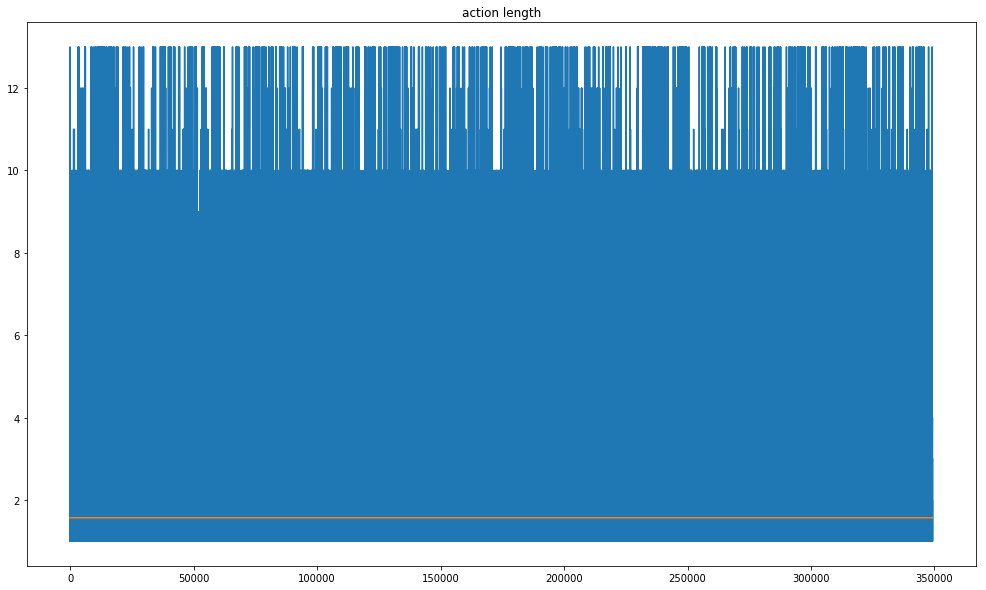

In [30]:
plt.figure(figsize=(17,10))
plt.plot(actions_length)
plt.plot([np.mean(actions_length)] * len(actions_length))
plt.title('action length')
plt.show()

## Actions frequency

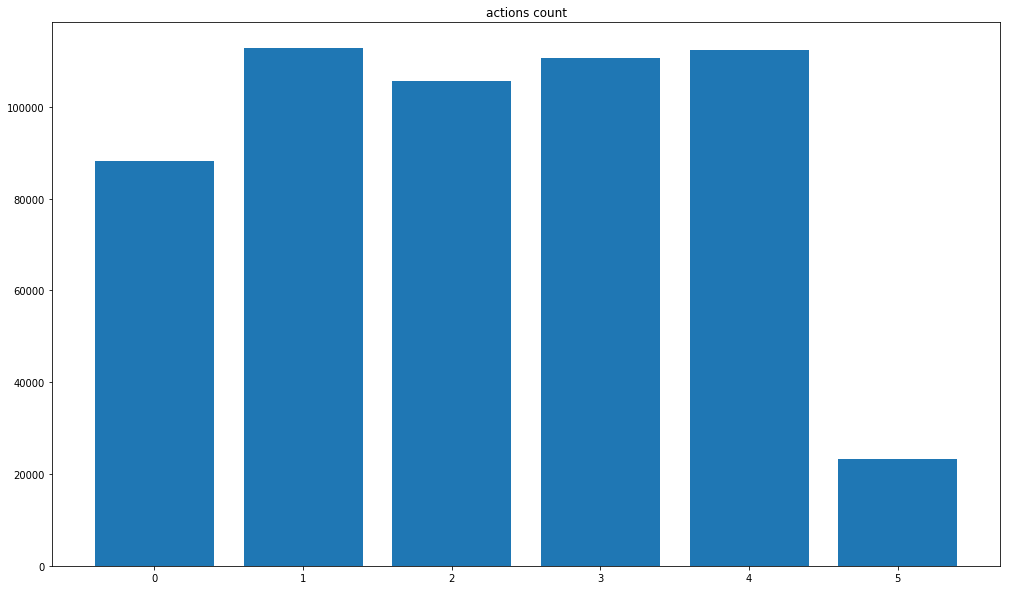

In [31]:
actions_count = np.zeros(6)
for episode in episodes:    
    for action in episode.actions:
        actions_count[action] += 1
        
plt.figure(figsize=(17,10))
plt.bar(range(0,6), actions_count)
plt.title('actions count')
plt.show()

# Some data preprocessing

Remove episodes with too small length. Maybe it is suicide.

In [21]:
episodes = [episode for episode in episodes if episode.get_num_steps() > 35 or episode.reward[-1] == 1]
len(episodes)

2202

Let's remove consequtive actions. I will use threshold 12.

In [22]:
threshold = 12

for episode in tqdm(episodes):
    # New observations
    obs = []
    act = []
    rew = []
    
    # Initial values
    cur_action = episode.actions[0]
    seq_length = 0
    for ind in range(len(episode.actions)):
        # Current action
        action = episode.actions[ind]
        
        # If an action the same
        if action == cur_action:
            seq_length += 1
        else:
            seq_length = 0
            cur_action = action
        # If a sequence is less than threashold
        if seq_length <= threshold:
            obs.append(episode.observations[ind])
            act.append(episode.actions[ind])
            rew.append(episode.reward[ind])
    
    # Save preprocessed observations
    episode.actions      = act
    episode.observations = obs
    episode.reward       = rew

Let's rerun plots.

## Save stuff

In [32]:
observations = []
actions = []
rewards = []
for episode in episodes:
    observations.extend(episode.observations)
    actions.extend(episode.actions)
    rewards.extend(episode.reward)

observations = np.array(observations)
actions = np.array(actions)
rewards = np.array(rewards)

In [33]:
np.save(train_data_obs, observations)
np.save(train_data_labels, actions)
np.save(train_data_reward, rewards)

In [ ]:
observations = np.load(train_data_obs)
actions      = np.load(train_data_labels)
rewards      = np.load(train_data_reward)

In [34]:
observations.shape, actions.shape, rewards.shape

((553065,), (553065,), (553065,))

## Featurize

In [143]:
def featurize(obs):
    shape = (BOARD_SIZE, BOARD_SIZE, 1)

    def get_matrix(board, key):
        res = board[key]
        return res.reshape(shape).astype(np.float32)

    def get_map(board, item):
        map = np.zeros(shape)
        map[board == item] = 1
        return map

    board = get_matrix(obs, 'board')

    path_map       = get_map(board, 0)          # Empty space
    rigid_map      = get_map(board, 1)          # Rigid = 1
    wood_map       = get_map(board, 2)          # Wood = 2
    bomb_map       = get_map(board, 3)          # Bomb = 3
    flames_map     = get_map(board, 4)          # Flames = 4
    fog_map        = get_map(board, 5)          # TODO: not used for first two stages Fog = 5
    extra_bomb_map = get_map(board, 6)          # ExtraBomb = 6
    incr_range_map = get_map(board, 7)          # IncrRange = 7
    kick_map       = get_map(board, 8)          # Kick = 8
    skull_map      = get_map(board, 9)          # Skull = 9

    position = obs["position"]
    my_position = np.zeros(shape)
    my_position[position[0], position[1], 0] = 1

    team_mates = get_map(board, obs["teammate"].value) # TODO during documentation it should be an array

    enemies = np.zeros(shape)
    for enemy in obs["enemies"]:
        enemies[board == enemy.value] = 1

    bomb_blast_strength = get_matrix(obs, 'bomb_blast_strength')
    bomb_life           = get_matrix(obs, 'bomb_life')

    ammo           = np.full((BOARD_SIZE, BOARD_SIZE, 1), obs["ammo"])
    blast_strength = np.full((BOARD_SIZE, BOARD_SIZE, 1), obs["blast_strength"])
    can_kick       = np.full((BOARD_SIZE, BOARD_SIZE, 1), int(obs["can_kick"]))
    
    obs = np.concatenate([my_position, enemies, team_mates, path_map, rigid_map, 
                          wood_map, bomb_map, flames_map, fog_map, extra_bomb_map,
                          incr_range_map, kick_map, skull_map, bomb_blast_strength,
                          bomb_life, ammo, blast_strength, can_kick], axis=2)
    return obs.astype(np.int16)

In [144]:
observations_map = []
for obs in tqdm(observations):
    observations_map.append(featurize(obs))

In [146]:
np.save(train_data_obs_map, observations_map)